*First compiled: May 3, 2017. Updated Mar 28, 2018.*   
See the same notebook for Scanpy [0.2.7](https://github.com/theislab/scanpy_usage/blob/17c34b61f76de79bfdea7512f1782bf3f5ecb160/170503_zheng17/zheng17_pbmc68k_cellranger_Py.ipynb).

# Profiling Scanpy  for 68k PBMC cells of [Zheng *et al.*, Nat. Comm. (2017)](https://doi.org/10.1038/ncomms14049)

This is the *Scanpy* benchmark for the *Cell Ranger* R analysis of [Zheng *et al.*, Nat. Comms. (2017)](https://doi.org/10.1038/ncomms14049) available from [here](https://github.com/10XGenomics/single-cell-3prime-paper). Compare the Scanpy version with the [Cell Ranger version of this notebook](zheng17_R.ipynb).

The data is freely available [[page](https://support.10xgenomics.com/single-cell/datasets/fresh_68k_pbmc_donor_a)/[file](https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/fresh_68k_pbmc_donor_a/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz)] from the 10x homepage and from [GitHub](https://github.com/10XGenomics/single-cell-3prime-paper).

A more pedagogic tutorial can be found [here](https://github.com/theislab/scanpy_usage/tree/master/170505_seurat).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/zheng17.h5ad'

scanpy==1.3.2 anndata==0.6.11 numpy==1.14.6 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 


Initial usage of memory.

In [3]:
sc.logging.print_memory_usage()

Memory usage: current 0.13 GB, difference +0.13 GB


Only use the first n cells, set to `None` if you want all cells.

In [4]:
use_first_n_observations = None

Load the data. This takes a long time only when first reading the raw data from the `.mtx` text file. It's very fast through reading from the `./cache/` directory after that (change this using `sc.settings.cachedir`).

In [1]:
%%time
path = './data/filtered_matrices_mex/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

NameError: name 'sc' is not defined

In [16]:
display(adata.var_names)
print(adata.var_names.shape)
display(adata.obs_names)
print(adata.obs_names.shape)

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

(32738,)


Index(['AAACATACACCCAA-1', 'AAACATACCCCTCA-1', 'AAACATACCGGAGA-1',
       'AAACATACTAACCG-1', 'AAACATACTCTTCA-1', 'AAACATACTGGATC-1',
       'AAACATACTGTCTT-1', 'AAACATACTTCTAC-1', 'AAACATTGCTGCTC-1',
       'AAACATTGCTTCGC-1',
       ...
       'TTTGACTGCTTTAC-8', 'TTTGACTGTATCGG-8', 'TTTGACTGTCGTTT-8',
       'TTTGACTGTGCTAG-8', 'TTTGCATGACACCA-8', 'TTTGCATGAGCCTA-8',
       'TTTGCATGCTAGCA-8', 'TTTGCATGCTGCAA-8', 'TTTGCATGGCTCCT-8',
       'TTTGCATGTGGTAC-8'],
      dtype='object', name=0, length=68579)

(68579,)


In [6]:
adata.var_names_make_unique()

Let us use the cell type labels generated by Zheng *et al.* by correlating gene expression with purified bulk data. You can download the bulk labels here [./data/zheng17_bulk_lables.txt](./data/zheng17_bulk_lables.txt).

In [10]:
adata.obs['bulk_labels'] = pd.read_csv('./data/zheng17_bulk_lables.txt', header=None)[0].values

Reduce the number of observations for scaling information.

In [31]:
print(adata.obs['bulk_labels'].shape)
adata.obs['bulk_labels'].unique()

(68579,)


array(['CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic',
       'CD4+/CD25 T Reg', 'CD19+ B', 'CD4+/CD45RO+ Memory', 'Dendritic',
       'CD56+ NK', 'CD34+', 'CD4+/CD45RA+/CD25- Naive T',
       'CD14+ Monocyte', 'CD4+ T Helper2'], dtype=object)

In [18]:
adata = adata[:use_first_n_observations]

Save the logarithmized raw data for differential expression testing and plotting.

In [19]:
sc.pp.log1p(adata, copy=True).write('./write/zheng17_raw.h5ad')

... storing 'bulk_labels' as categorical


In [20]:
adata

View of AnnData object with n_obs × n_vars = 68579 × 32738 
    obs: 'bulk_labels'

### Preprocessing

Instead of calling all steps of this preprocessing section separtely, you can call    

[`sc.pp.recipe_zheng17(adata)`](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html)

Per-cell normalize the data matrix $X$ and identify highly-variable genes. 

In [21]:
%%time
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 1.00 GB, difference +0.87 GB
Wall time: 3.55 s


Plot the dispersion relation. Use a logarithmic scale as the data is not yet logarithmized.

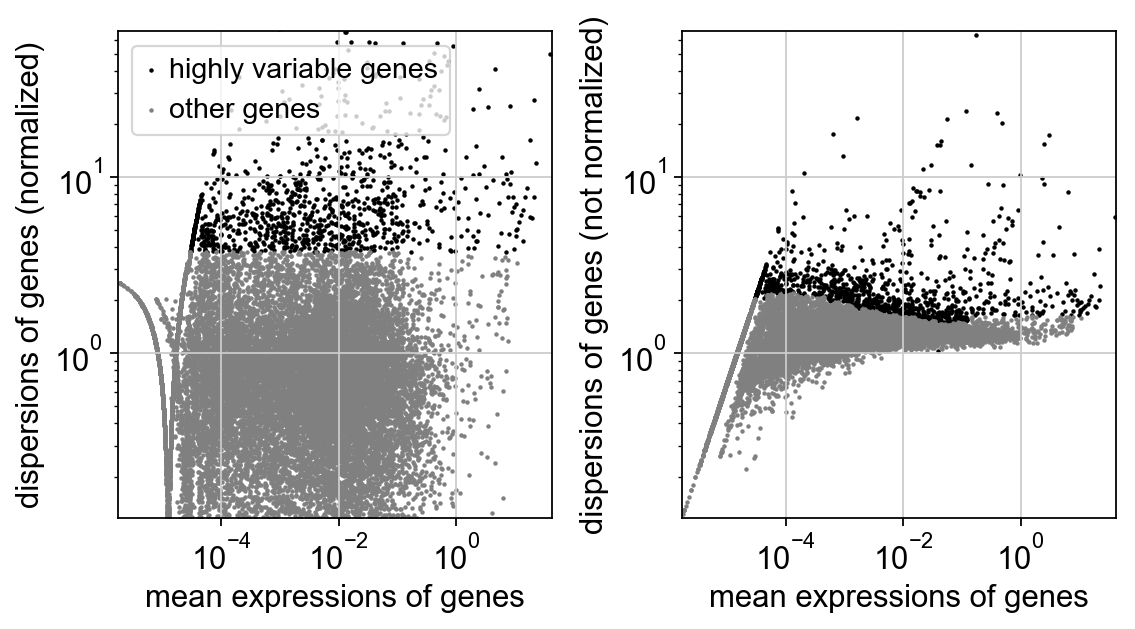

In [22]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

Normalize the data again, logarithmize and scale the data. Then compute the PCA.

In [23]:
%%time
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata)
# the PCA is *not* contained in the recipe sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 0.82 GB, difference -0.18 GB
Wall time: 7.85 s


Plot the PCA results.

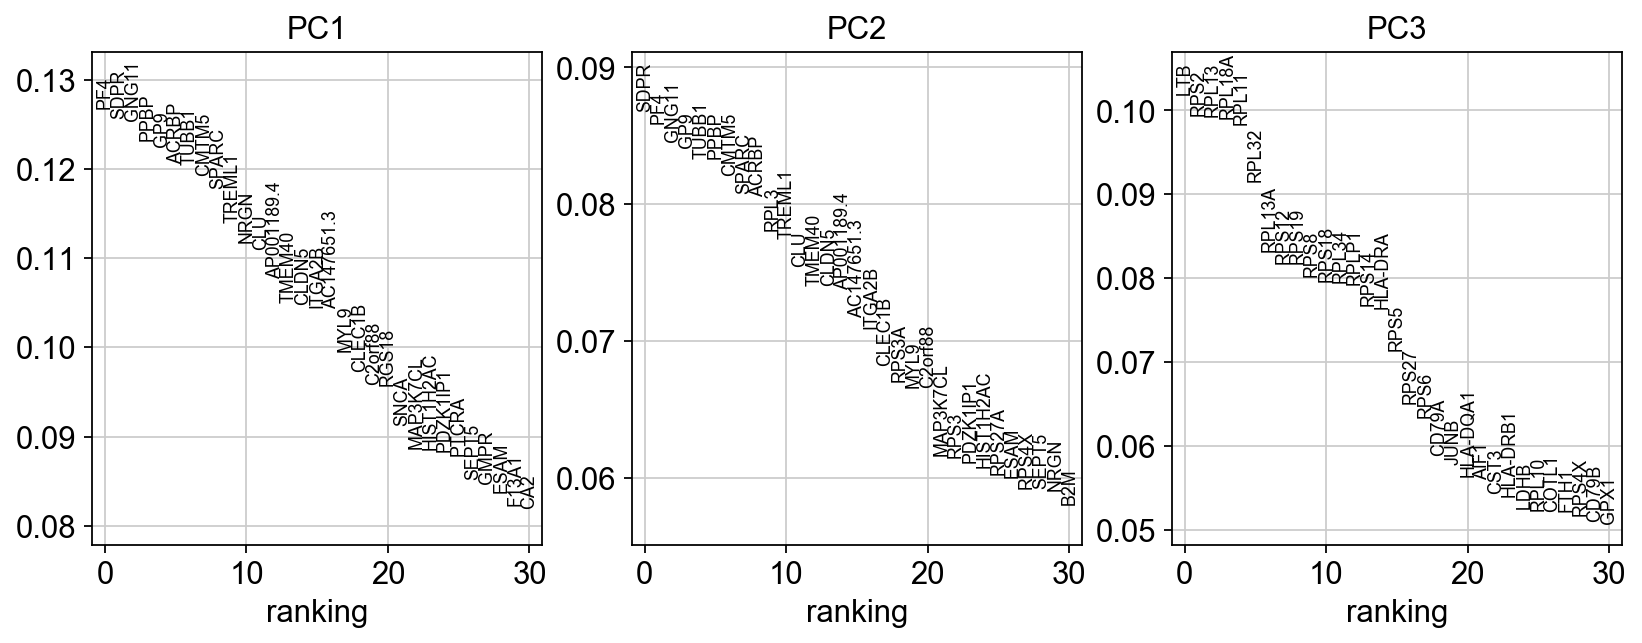

In [25]:
sc.pl.pca_loadings(adata)

### Constructing and visualizing the single-cell graph

This will construct the single-cell graph - usually a knn graph - that describes cells in their relation to their neighbors.

In [26]:
%%time
sc.pp.neighbors(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.89 GB, difference +0.08 GB
Wall time: 40.1 s


In [27]:
%%time
sc.tl.umap(adata)
sc.logging.print_memory_usage()

Memory usage: current 0.90 GB, difference +0.00 GB
Wall time: 1min 17s


... storing 'bulk_labels' as categorical


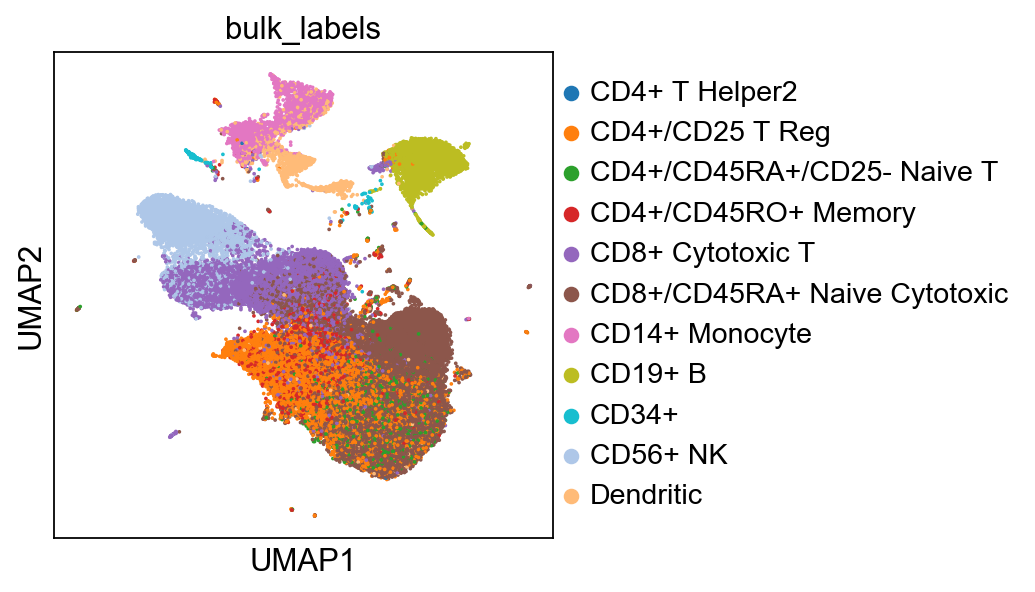

In [32]:
sc.pl.umap(adata, color='bulk_labels')

### Clustering the single-cell graph

Instead of providing a simple k-means clustering as in Cell Ranger, we use the Louvain algorithm of [Blondel *et al.* (2008)](https://doi.org/10.1088/1742-5468/2008/10/P10008), as suggested by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.047) for single-cell analysis.

In [33]:
%%time
sc.tl.louvain(adata, resolution=0.3)
sc.logging.print_memory_usage()

ModuleNotFoundError: No module named 'igraph'

Plot the clusters.

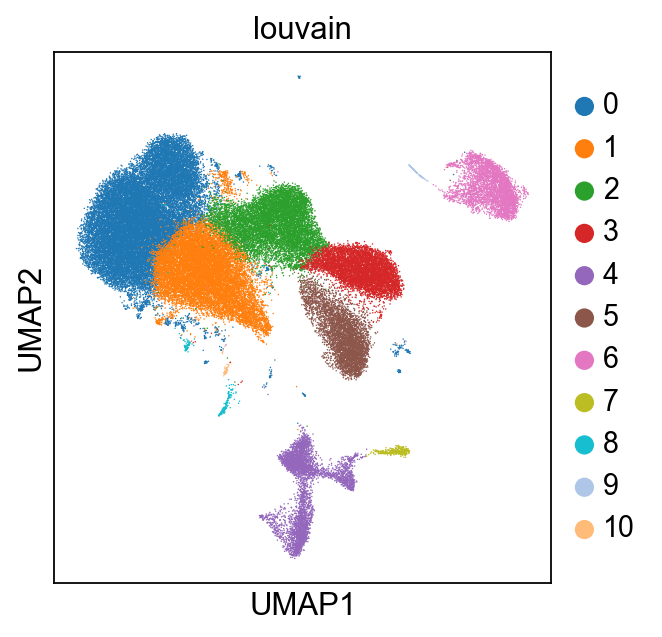

In [22]:
sc.pl.umap(adata, color='louvain')

### Marker Genes

Use the logarithmized raw data to rank genes according to differential expression.

In [24]:
adata.raw = sc.read('./write/zheng17_raw.h5ad')

In [25]:
%%time
sc.tl.rank_genes_groups(adata, 'louvain', groups=['1', '6', '9', '7'])
sc.logging.print_memory_usage()

Memory usage: current 1.44 GB, difference +0.57 GB
CPU times: user 6.95 s, sys: 3.71 s, total: 10.7 s
Wall time: 10.9 s


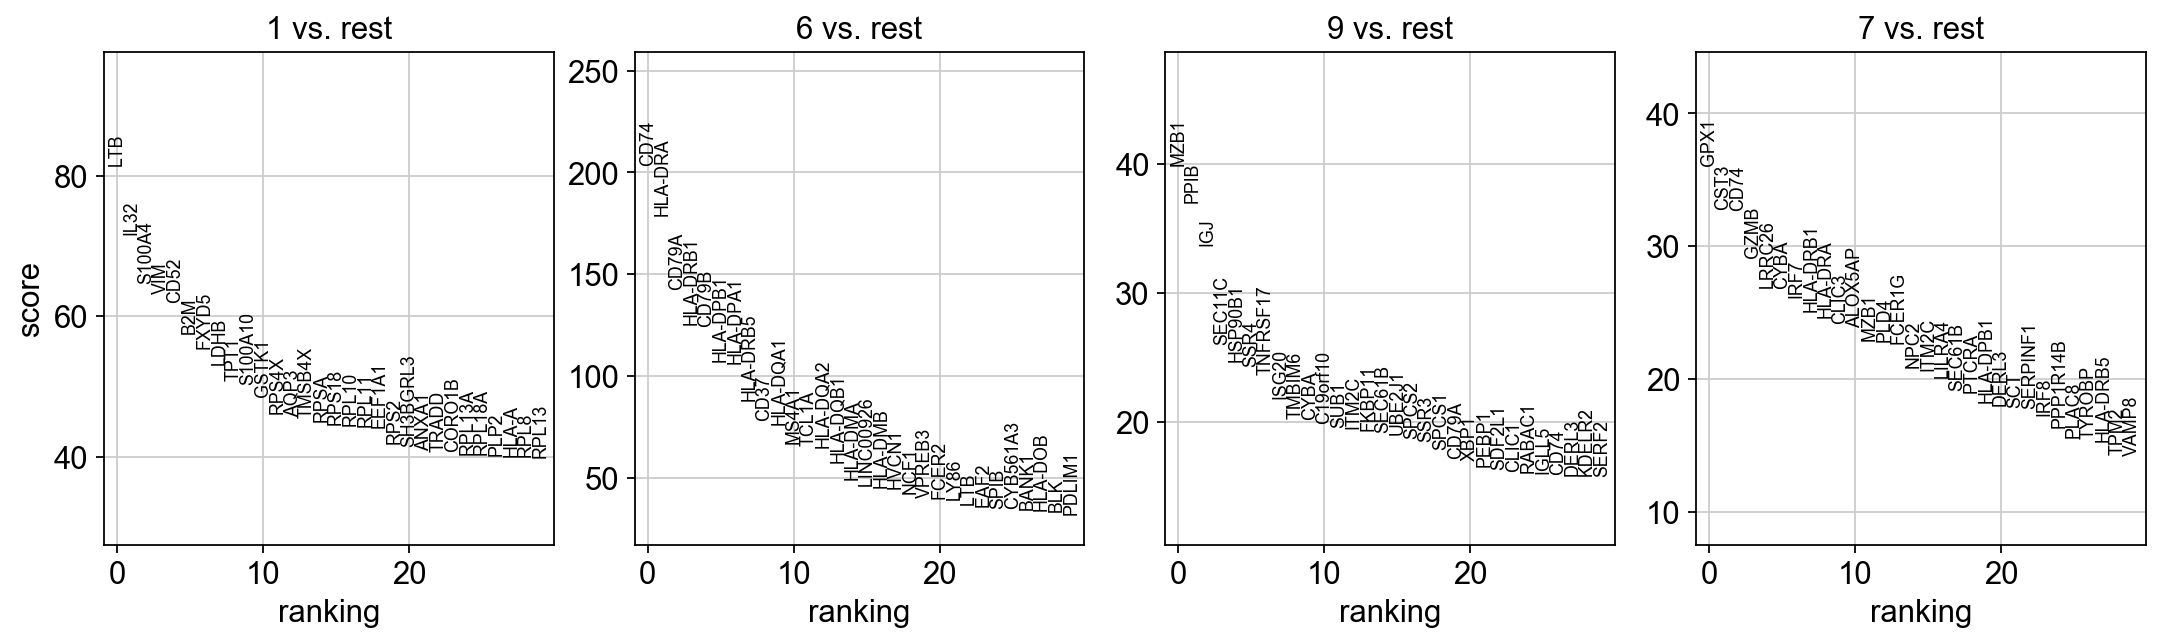

In [26]:
sc.pl.rank_genes_groups(adata, n_genes=30)

We do not want to save it the raw data in the same file... to avoid it, set it to None again.

In [6]:
adata.raw = None

### Alternative visualization using tSNE

Compute tSNE. This can, even on a single core, be sped up significantly by installing https://github.com/DmitryUlyanov/Multicore-TSNE, which is automatically detected by Scanpy.

In [21]:
%%time
sc.tl.tsne(adata)
sc.logging.print_memory_usage()

Memory usage: current 1.35 GB, difference +0.23 GB
CPU times: user 7min 17s, sys: 13.1 s, total: 7min 30s
Wall time: 5min 17s


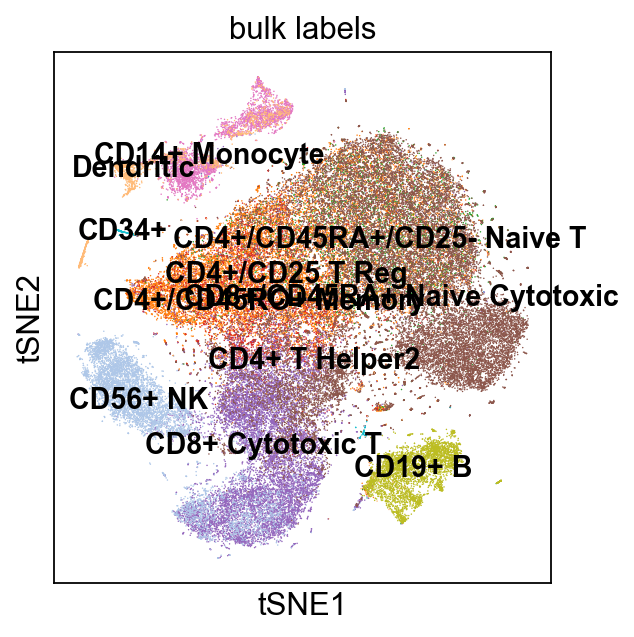

In [22]:
sc.pl.tsne(adata, color='bulk_labels', legend_loc='on data')

In [23]:
adata.write(results_file)